<a href="https://colab.research.google.com/github/RaynierRaja/Garbage_Classifier/blob/master/MyGarbageClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
pip install tensorflow-gpu==2.0.0

In [0]:
pip install tensorflow_hub

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd

In [0]:
pd.set_option("display.precision", 8)

In [0]:
from google.colab import drive

In [0]:
drive.mount('/content/drive')

In [0]:
data_root='/content/drive/My Drive/TFLITE/garbage'

In [13]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/My Drive/TFLITE/garbage
Found 397 images belonging to 4 classes.
Found 1593 images belonging to 4 classes.


In [14]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 4)
['Glass' 'Metal' 'Paper' 'Plastic']


In [15]:
model = tf.keras.Sequential([
hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4",
output_shape=[1280],
trainable=False),
tf.keras.layers.Dropout(0.4),
tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])
model.build([None, 224, 224, 3])
model.summary()
model.compile(
optimizer=tf.keras.optimizers.Adam(),
loss='categorical_crossentropy',
metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     multiple                  2257984   
_________________________________________________________________
dropout (Dropout)            multiple                  0         
_________________________________________________________________
dense (Dense)                multiple                  5124      
Total params: 2,263,108
Trainable params: 5,124
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
steps_per_epoch = np.ceil(train_generator.samples/train_generator.batch_size)
val_steps_per_epoch = np.ceil(valid_generator.samples/valid_generator.batch_size)
hist = model.fit(
train_generator,
epochs=10,
verbose=1,
steps_per_epoch=steps_per_epoch,
validation_data=valid_generator,
validation_steps=val_steps_per_epoch).history

Train for 50.0 steps, validate for 13.0 steps
Epoch 1/10
50/50 [==============================] - 186s 4s/step - loss: 1.1168 - acc: 0.5411 - val_loss: 0.6419 - val_acc: 0.7330
Epoch 2/10
50/50 [==============================] - 11s 225ms/step - loss: 0.5557 - acc: 0.7772 - val_loss: 0.5331 - val_acc: 0.7683
Epoch 3/10
50/50 [==============================] - 11s 219ms/step - loss: 0.4846 - acc: 0.8117 - val_loss: 0.4979 - val_acc: 0.7859
Epoch 4/10
50/50 [==============================] - 11s 217ms/step - loss: 0.4148 - acc: 0.8487 - val_loss: 0.4678 - val_acc: 0.7884
Epoch 5/10
50/50 [==============================] - 11s 220ms/step - loss: 0.3740 - acc: 0.8500 - val_loss: 0.4510 - val_acc: 0.8111
Epoch 6/10
50/50 [==============================] - 11s 218ms/step - loss: 0.3371 - acc: 0.8782 - val_loss: 0.4680 - val_acc: 0.7859
Epoch 7/10
50/50 [==============================] - 11s 218ms/step - loss: 0.3002 - acc: 0.8864 - val_loss: 0.4241 - val_acc: 0.8161
Epoch 8/10
50/50 [=======

In [0]:
Garbage_SAVED_MODEL = "saved_models/garbage"
tf.keras.experimental.export_saved_model(model, Garbage_SAVED_MODEL)
garbage_model = tf.keras.experimental.load_from_saved_model(Garbage_SAVED_MODEL,
custom_objects={'KerasLayer':hub.KerasLayer})

In [33]:
val_image_batch, val_label_batch = next(iter(valid_generator))
true_label_ids = np.argmax(val_label_batch, axis=-1)
print("Validation batch shape:", val_image_batch.shape)

Validation batch shape: (32, 224, 224, 3)


In [34]:
tf_model_predictions = garbage_model.predict(val_image_batch)
tf_pred_dataframe = pd.DataFrame(tf_model_predictions)
tf_pred_dataframe.columns = dataset_labels
print("Prediction results for the first elements")
tf_pred_dataframe.head()

Prediction results for the first elements


,Glass,Metal,Paper,Plastic
0,0.00097348,0.99886727,0.00012831,0.00003102
1,0.55678266,0.06114291,0.00583416,0.37624034
2,0.66594541,0.31917202,0.00026269,0.01461990
3,0.28050959,0.66116935,0.01262688,0.04569412
4,0.99715900,0.00149086,0.00004447,0.00130563


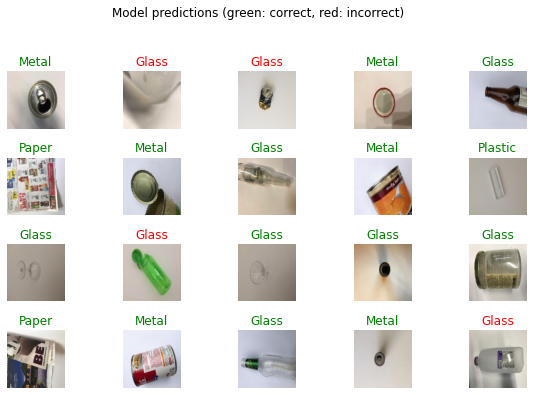

In [35]:
predicted_ids = np.argmax(tf_model_predictions, axis=-1)
predicted_labels = dataset_labels[predicted_ids]
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(20):
  plt.subplot(6,5,n+1)
  plt.imshow(val_image_batch[n])
  color = "green" if predicted_ids[n] == true_label_ids[n] else "red"
  plt.title(predicted_labels[n].title(), color=color)
  plt.axis('off')
  _ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
!mkdir "tflite_models"
TFLITE_MODEL = "tflite_models/garbage.tflite"
TFLITE_QUANT_MODEL = "tflite_models/garbage_quant.tflite"

In [0]:
run_model = tf.function(lambda x : garbage_model(x))
# Save the concrete function.
concrete_func = run_model.get_concrete_function(
tf.TensorSpec(model.inputs[0].shape, model.inputs[0].dtype)
)
# Convert the model
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converted_tflite_model = converter.convert()
open(TFLITE_MODEL, "wb").write(converted_tflite_model)
# Convert the model to quantized version with post-training quantization
converter = tf.lite.TFLiteConverter.from_concrete_functions([concrete_func])
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_quant_model = converter.convert()
open(TFLITE_QUANT_MODEL, "wb").write(tflite_quant_model)
print("TFLite models and their sizes:")
!ls "tflite_models" -lh